In [ ]:
import gym
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import time
from matplotlib import animation
import matplotlib.pyplot as plt

In [ ]:
!pip install ufal.pybox2d

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 29.5 MB/s eta 0:00:00


iteration: 0 mean total reward: -175.4449575925684
iteration: 1 mean total reward: -164.5370448085917
iteration: 2 mean total reward: -163.5977904313081
iteration: 3 mean total reward: -167.8827905989373
iteration: 4 mean total reward: -155.35783283737305
iteration: 5 mean total reward: -155.71083184817232
iteration: 6 mean total reward: -165.4486429243505
iteration: 7 mean total reward: -147.2843852262922
iteration: 8 mean total reward: -130.47676426908984
iteration: 9 mean total reward: -112.04108938041298
iteration: 10 mean total reward: -116.53637814923404
iteration: 11 mean total reward: -118.39189940196675
iteration: 12 mean total reward: -96.94075275938708
iteration: 13 mean total reward: -105.48899629305342
iteration: 14 mean total reward: -111.61951728126644
iteration: 15 mean total reward: -112.10361615613888
iteration: 16 mean total reward: -125.61977941737578
iteration: 17 mean total reward: -123.34750550999756
iteration: 18 mean total reward: -117.96156299956138
iteration:

/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


total reward: 270.01951491536806


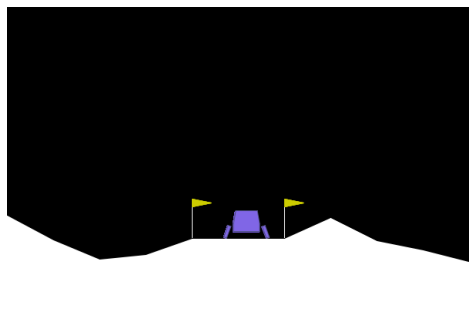

In [ ]:
env = gym.make('LunarLander-v2')
state_dim = 8
action_n = 4

class CEM(nn.Module):

    def __init__(self, state_dim, action_n):
        super().__init__()
        self.state_dim = state_dim
        self.action_n = action_n

        self.network = nn.Sequential(nn.Linear(self.state_dim, 128),
                                     nn.ReLU(),
                                     nn.Linear(128, self.action_n)
                                     )

        self.softmax = nn.Softmax()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-2)
        self.loss = nn.CrossEntropyLoss()


    def forward(self, _input):
        return self.network(_input)

    def get_action(self, state):
        state = torch.FloatTensor(state)
        logits = self.forward(state)
        probs = self.softmax(logits).data.numpy()
        action = np.random.choice(self.action_n, p=probs)

        return action


    def fit(self, elite_trajectories):
        elite_states = []
        elite_actions = []
        for trajectory in elite_trajectories:
          for state, action in zip(trajectory['states'], trajectory['actions']):
            elite_states.append(state)
            elite_actions.append(action)
        elite_states = torch.FloatTensor(elite_states)
        elite_actions = torch.LongTensor(elite_actions)

        pred_actions = self.forward(elite_states)

        loss = self.loss(pred_actions, elite_actions)
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()


def get_trajectory(env, agent, max_len=1000, visualize=False):
    trajectory = {'states':[], 'actions': [], 'rewards': []}

    state = env.reset()

    for _ in range(max_len):
        trajectory['states'].append(state)

        action = agent.get_action(state)
        trajectory['actions'].append(action)

        state, reward, done, _ = env.step(action)
        trajectory['rewards'].append(reward)

        if visualize:
            time.sleep(0.01)
            env.render()

        if done:
            break

    return trajectory


agent = CEM(state_dim, action_n)
q_param = 0.9
trajectory_len = 500
trajectory_n = 100
iteration_n = 200


mean_rewards = []

for iteration in range(iteration_n):

    #policy evaluation

    #the array of trajectories
    trajectories = [get_trajectory(env, agent) for _ in range(trajectory_n)]
    #the array of total reward
    total_rewards = [np.sum(trajectory['rewards']) for trajectory in trajectories]
    #and we need average
    print('iteration:', iteration, 'mean total reward:', np.mean(total_rewards))
    mean_rewards.append(np.mean(total_rewards))
    #policy improvement (gamma-q)
    quantile = np.quantile(total_rewards, q_param)
    #remain only elite trajectories
    elite_trajectories = []
    for trajectory in trajectories:
        total_reward = np.sum(trajectory['rewards'])
        if total_reward > quantile:
            elite_trajectories.append(trajectory)

    if len(elite_trajectories) > 0:
      agent.fit(elite_trajectories)




trajectory = get_trajectory(env, agent, max_len=500, visualize=True)
print('total reward:', sum(trajectory['rewards']))

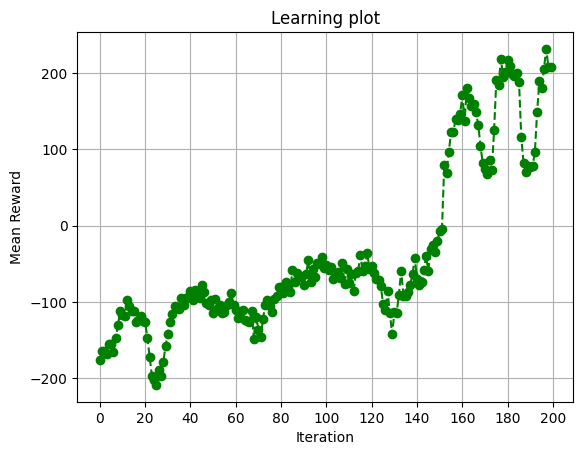

In [ ]:
# Create plot
plt.plot(mean_rewards, color='green', marker='o', linestyle='--')

# Add title and labels
plt.title('Learning plot')
plt.xlabel('Iteration')
plt.ylabel('Mean Reward')
plt.xticks(range(0, iteration_n+1, 20))

# Add grid
plt.grid(True)